In [2]:
### Install libraries ###

!pip install git+https://github.com/HumanCompatibleAI/overcooked_ai.git

  Cloning https://github.com/HumanCompatibleAI/overcooked_ai.git to /tmp/pip-req-build-3a4hzuty
  Running command git clone --filter=blob:none --quiet https://github.com/HumanCompatibleAI/overcooked_ai.git /tmp/pip-req-build-3a4hzuty
  Resolved https://github.com/HumanCompatibleAI/overcooked_ai.git to commit 89aa083d46dd5673967f1259f84b30ee887ec068
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.8/847.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 45.0 MB/s eta 0:00:00
  Created wheel for overcooked-ai: filename=overcooked_ai-1.1.0-py3-none-any.whl size=10722398 sha256=e493b4f08a5e36f34f0c685241e16ecead8724eb67c59110e57790c0d6a758b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-k1opi1tk/wheels/70/0a/7e/1eec7737819d229798c2e79de5989bbf0c24e4be

In [1]:
"""
Project3 Overcooked AI
tdpham328
"""


### Imports ###

from overcooked_ai_py.mdp.overcooked_mdp import OvercookedGridworld
from overcooked_ai_py.mdp.overcooked_env import OvercookedEnv
from overcooked_ai_py.agents.agent import NNPolicy, AgentFromPolicy, AgentPair
from overcooked_ai_py.agents.benchmarking import AgentEvaluator
from overcooked_ai_py.visualization.state_visualizer import StateVisualizer
import gym
import numpy as np
import matplotlib.pyplot as plt

import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from PIL import Image
import os
from IPython.display import display, Image as IPImage

## Uncomment if you'd like to use your personal Google Drive to store outputs
## from your runs. You can find some hooks to Google Drive commented
## throughout the rest of this code.
# from google.colab import drive

class DQN(nn.Module):
    def __init__(self, alpha, state_dim, action_dim, hidden_dims):
        super(DQN, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.hidden_dims = hidden_dims

        self.fc1 = nn.Linear(*self.state_dim, self.hidden_dims[0])
        # self.fc1_bn = nn.BatchNorm1d(self.hidden_dims[0])
        # self.fc1_ln = nn.LayerNorm(self.hidden_dims[0])
        self.fc2 = nn.Linear(self.hidden_dims[0], self.hidden_dims[1])
        # self.fc2_ln = nn.LayerNorm(self.hidden_dims[1])
        # self.fc2_bn = nn.BatchNorm1d(self.hidden_dims[1])
        self.fc3 = nn.Linear(self.hidden_dims[1], self.action_dim)
        # self.dropout = nn.Dropout(p = 0.1)
        self.double()
        # self.float()

        self.optimizer = optim.Adam(self.parameters(), lr = alpha)
        self.loss = nn.SmoothL1Loss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        #self.device = T.device('cpu')
        self.to(self.device)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc1_ln(self.fc1(x)))
        # x = self.dropout(x)
        x = F.relu(self.fc2(x))
        # x = F.relu(self.fc2_ln(self.fc2(x)))
        return self.fc3(x)

# Define Replay Buffer
class ReplayBuffer():
    def __init__(self, state_dim, action_dim, max_mem_size):
        self.max_mem_size = max_mem_size
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.a0_state_memory = np.zeros((max_mem_size, *state_dim), dtype = np.float64)
        self.a1_state_memory = np.zeros((max_mem_size, *state_dim), dtype = np.float64)
        self.a0_action_memory = np.zeros(max_mem_size, dtype = np.int32)
        self.a1_action_memory = np.zeros(max_mem_size, dtype = np.int32)
        self.a0_new_state_memory = np.zeros((max_mem_size, *state_dim), dtype = np.float64)
        self.a1_new_state_memory = np.zeros((max_mem_size, *state_dim), dtype = np.float64)
        self.reward_memory = np.zeros(max_mem_size, dtype = np.float32)
        self.terminal_memory = np.zeros(max_mem_size, dtype = np.bool_)
        self.mem_counter = 0


# Define the agent
class Agent():
    def __init__(self, gamma, epsilon, alpha, state_dim, action_dim,
                 eps_min, eps_decay):
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.action_list = [i for i in range(action_dim)]

        # Q-network
        # Set up 2 different Q-network for online network and target network
        self.Q_network = DQN(self.alpha, action_dim = action_dim, state_dim= state_dim, hidden_dims = [128,128])
        self.Q_target = DQN(self.alpha, action_dim = action_dim, state_dim= state_dim, hidden_dims = [128,128])
        self.Q_target.load_state_dict(self.Q_network.state_dict())

        # # Set up a buffer to store the experience (current state, action, reward, new state, terminal state)
        # self.state_memory = np.zeros((self.max_mem_size, *state_dim), dtype = np.float64)
        # self.action_memory = np.zeros(self.max_mem_size, dtype = np.int32)
        # self.new_state_memory = np.zeros((self.max_mem_size, *state_dim), dtype = np.float64)
        # self.reward_memory = np.zeros(self.max_mem_size, dtype = np.float32)
        # self.terminal_memory = np.zeros(self.max_mem_size, dtype = np.bool_)

    def ChooseAction(self,observation):
        # random chance of exploration phase
        if np.random.random() <= self.epsilon:
            return np.random.choice(self.action_list)
        # greedy pick
        else:
            state = T.tensor([observation]).to(self.Q_network.device)
            return T.argmax(self.Q_network.forward(state)).item()

    # function to update the Q target network
    def update_target_network(self):
        self.Q_target.load_state_dict(self.Q_network.state_dict())
    # SOFT UPDATE TARGET NETWORK
    def soft_update_target_network(self, tau = 0.001):
        for target_param, local_param in zip(self.Q_target.parameters(), self.Q_network.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

if __name__ == '__main__':

    ### Environment setup ###

    ## Swap between the 5 layouts here:

    # layout = "cramped_room"
    # layout = "asymmetric_advantages"
    layout = "coordination_ring"
    # layout = "forced_coordination"
    # layout = "counter_circuit_o_1order"

    ## Reward shaping is disabled by default; i.e., only the sparse rewards are
    ## included in the reward returned by the enviornment).  If you'd like to do
    ## reward shaping (recommended to make the task much easier to solve), this
    ## data structure provides access to a built-in reward-shaping mechanism within
    ## the Overcooked environment.  You can, of course, do your own reward shaping
    ## in lieu of, or in addition to, using this structure. The shaped rewards
    ## provided by this structure will appear in a different place (see below)
    reward_shaping = {
        "PLACEMENT_IN_POT_REW": 1,
        "DISH_PICKUP_REWARD": 3,
        "SOUP_PICKUP_REWARD": 5
    }

    # Length of Episodes.  Do not modify for your submission!
    # Modification will result in a grading penalty!
    horizon = 400

    # Build the environment.  Do not modify!
    mdp = OvercookedGridworld.from_layout_name(layout, rew_shaping_params=reward_shaping)
    base_env = OvercookedEnv.from_mdp(mdp, horizon=horizon, info_level=0)
    env = gym.make("Overcooked-v0", base_env=base_env, featurize_fn=base_env.featurize_state_mdp)

    # SET UP AGENT
    agent0 = Agent(gamma = 0.9, epsilon = 1.00, alpha = 0.0003, state_dim=[96],
                  action_dim = 6, eps_min= 0.15, eps_decay=0.00001)
    agent1 = Agent(gamma = 0.9, epsilon = 1.00, alpha = 0.0003, state_dim=[96],
                  action_dim = 6, eps_min= 0.15, eps_decay=0.00001)
    buffer = ReplayBuffer(state_dim=[96],action_dim = 6, max_mem_size= 100000)
    buffer.mem_counter = 0
    batch_size = 1024

    ### Train your agent ###
    # The code below runs a few episodes with a random agent.  Your learning algorithm
    # would go here.
    soup_final = []
    dish_pickup = []
    potting_onion = []
    soup_SMA100 = []
    num_episodes = 1500

    for e in range(num_episodes):
        # Episode termination flag
        terminal = False
        # The number of soups the agent pair made during the episode
        num_soups_made = 0
        # Reset the environment at the start of each episode
        obs = env.reset()
        combined_reward = 0
        total_reward = 0
        r_0 = 0
        r_1 = 0
        upd_target_counter = 0

        while not terminal:
            # set pointer to go back overwrite oldest mem if full
            pointer = buffer.mem_counter % buffer.max_mem_size

            # Obtain observations for each agent
            if env.agent_idx:
                obs0 = obs["both_agent_obs"][1]
                obs1 = obs["both_agent_obs"][0]
            else:
                obs0 = obs["both_agent_obs"][0]
                obs1 = obs["both_agent_obs"][1]

            # EXPERIENCE/STEP
            a0 = agent0.ChooseAction(obs0)
            a1 = agent1.ChooseAction(obs1)
            if env.agent_idx:
                obs, R, terminal, info = env.step([a1,a0])
            else:
                obs, R, terminal, info = env.step([a0,a1])

            # You can find the separate shaping rewards induced by the data
            # structure you defined above in the "info" dictionary.
            ## THE REVERSAL OF THIS ARRAY IS NECESSARY TO ALIGN THE CORRECT REWARD
            ## TO THE CORRECT AGENT (see project documentation)!
            # Note that this shaping reward does *not* include the +20 reward for
            # completed soups (the one returned in "R").

            r_shaped = info["shaped_r_by_agent"]

            if env.agent_idx:
                r_shaped_0 = r_shaped[1]
                r_shaped_1 = r_shaped[0]
            else:
                r_shaped_0 = r_shaped[0]
                r_shaped_1 = r_shaped[1]

            combined_reward = r_shaped_0 +r_shaped_1 + R
            total_reward += r_shaped_0 +r_shaped_1 + R
            r_0 += r_shaped_0
            r_1 += r_shaped_1

            buffer.a0_state_memory[pointer] = obs0
            buffer.a1_state_memory[pointer] = obs1
            buffer.a0_action_memory[pointer] = a0
            buffer.a1_action_memory[pointer] = a1
            buffer.reward_memory[pointer] = combined_reward
            if env.agent_idx:
                buffer.a0_new_state_memory[pointer] = obs["both_agent_obs"][1]
                buffer.a1_new_state_memory[pointer] = obs["both_agent_obs"][0]
            else:
                buffer.a0_new_state_memory[pointer] = obs["both_agent_obs"][0]
                buffer.a1_new_state_memory[pointer] = obs["both_agent_obs"][1]
            buffer.terminal_memory[pointer] = terminal
            buffer.mem_counter +=1

            # Doing a mirror memory:
            pointer = buffer.mem_counter % buffer.max_mem_size

            buffer.a0_state_memory[pointer] = obs1
            buffer.a1_state_memory[pointer] = obs0
            buffer.a0_action_memory[pointer] = a1
            buffer.a1_action_memory[pointer] = a0
            buffer.reward_memory[pointer] = combined_reward
            if env.agent_idx:
                buffer.a0_new_state_memory[pointer] = obs["both_agent_obs"][0]
                buffer.a1_new_state_memory[pointer] = obs["both_agent_obs"][1]
            else:
                buffer.a0_new_state_memory[pointer] = obs["both_agent_obs"][1]
                buffer.a1_new_state_memory[pointer] = obs["both_agent_obs"][0]
            buffer.terminal_memory[pointer] = terminal
            buffer.mem_counter +=1

            #TRAIN
            if buffer.mem_counter >= batch_size:
                agent0.Q_network.optimizer.zero_grad()
                agent1.Q_network.optimizer.zero_grad()

                batch_sample = np.random.choice(min(buffer.mem_counter, buffer.max_mem_size), batch_size, replace = False)

                a0_state = T.tensor(buffer.a0_state_memory[batch_sample]).to(agent0.Q_network.device)
                a0_new_state = T.tensor(buffer.a0_new_state_memory[batch_sample]).to(agent0.Q_network.device)
                a0_action = buffer.a0_action_memory[batch_sample]
                a0_reward = T.tensor(buffer.reward_memory[batch_sample]).to(agent0.Q_network.device)
                a0_terminal = T.tensor(buffer.terminal_memory[batch_sample]).to(agent0.Q_network.device)
                a1_state = T.tensor(buffer.a1_state_memory[batch_sample]).to(agent1.Q_network.device)
                a1_new_state = T.tensor(buffer.a1_new_state_memory[batch_sample]).to(agent1.Q_network.device)
                a1_action = buffer.a1_action_memory[batch_sample]
                a1_reward = T.tensor(buffer.reward_memory[batch_sample]).to(agent1.Q_network.device)
                a1_terminal = T.tensor(buffer.terminal_memory[batch_sample]).to(agent1.Q_network.device)

                # Update Q value
                batch_index = np.arange(batch_size, dtype = np.int32)
                q_current = (agent0.Q_network.forward(a0_state)[batch_index, a0_action] +
                                agent1.Q_network.forward(a1_state)[batch_index, a1_action])

                a0_q_next = agent0.Q_target.forward(a0_new_state)
                a1_q_next = agent1.Q_target.forward(a1_new_state)
                a0_q_next[a0_terminal] = 0.0
                a1_q_next[a1_terminal] = 0.0
                a0_max_action = T.argmax(agent0.Q_network.forward(a0_new_state), dim = 1)
                a1_max_action = T.argmax(agent1.Q_network.forward(a1_new_state), dim = 1)

                # a1_max_action = T.argmax(q_eval_next, dim = 1)
                q_target = a0_reward + (agent0.gamma * a0_q_next.gather(1, a0_max_action.unsqueeze(1)).squeeze(1)+
                                        agent1.gamma * a1_q_next.gather(1, a1_max_action.unsqueeze(1)).squeeze(1))


                # LOSS FUNCTION
                # loss = F.smooth_l1_loss(q_current, q_target)
                loss = agent0.Q_network.loss(q_target,q_current).to(agent0.Q_network.device)
                loss.backward()

                agent0.Q_network.optimizer.step()
                agent1.Q_network.optimizer.step()

                #Decay epsilon
                if agent0.epsilon > agent0.eps_min:
                    agent0.epsilon = agent0.epsilon - agent0.eps_decay
                else:
                    agent0.eps_min
                if agent1.epsilon > agent1.eps_min:
                    agent1.epsilon = agent1.epsilon - agent1.eps_decay
                else:
                    agent1.eps_min

            # Accumulate the number of soups made
            num_soups_made += int(R / 20) # Each served soup generates 20 reward
            agent0.soft_update_target_network()
            agent1.soft_update_target_network()
        # upd_target_counter += 1
        # if (upd_target_counter) == 3:
        #     agent0.update_target_network()
        #     agent1.update_target_network()
        #     upd_target_counter = 0

        soup_final.append(num_soups_made)
        soup_avg = np.mean(soup_final[-100:])
        dish_pickup.append(info['episode']['ep_game_stats']['dish_pickup'])
        potting_onion.append(info['episode']['ep_game_stats']['potting_onion'])
        soup_SMA100.append(soup_avg)

        # Display status
        print("Ep {0}".format(e + 1), end=" ")
        print("shaped reward agent 0: {0}:".format(r_0), end=" ")
        print("shaped reward agent 1: {0}".format(r_1), end=" ")
        print("total_reward: ", total_reward)
        print("no of soups made: {0}".format(num_soups_made))
        print("avg soup: {0}".format(soup_avg))
        print("eps0: ", agent0.epsilon)
        print("eps1: ", agent1.epsilon)

    # The info flag returned by the environemnt contains special status info
    # specifically when terminal == True.  This information may be useful in
    # developing, debugging, and analyzing your results.  It may also be a good
    # way for you to find a metric that you can use in evaluating collaboration
    # between your agents.
    print("\nExample end-of-episode info dump:\n", info)




ModuleNotFoundError: No module named 'overcooked_ai_py'

In [27]:
np.savetxt('lay3_soup_final.txt', soup_final)
np.savetxt('lay3_soup_SMA100.txt', soup_SMA100)

In [28]:
counts = []

# Iterate through each episode and agent pair
for episode_index, episode_agents in enumerate(potting_onion):
    episode_count = [0, 0]  # Initialize count for each agent in this episode
    for agent_index, agent_times in enumerate(episode_agents):
        episode_count[agent_index] = len(agent_times)
    counts.append(episode_count)

# Create a filename for the output
output_filename = "lay3_potting_onion.txt"

# Open the file for writing
with open(output_filename, "w") as output_file:
    # Write the header
    output_file.write("Episode\tAgent 1\tAgent 2\n")

    # Write the counts for each episode
    for episode, count in enumerate(counts, start=1):
        agent1_count, agent2_count = count
        output_file.write(f"{episode}\t{agent1_count}\t\t{agent2_count}\n")

print(f"Output saved to {output_filename}")

Output saved to lay3_potting_onion.txt


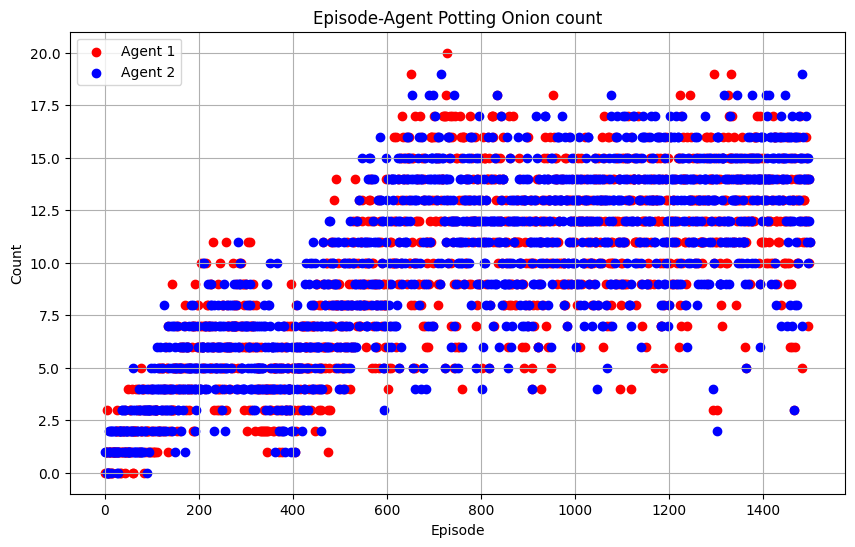

In [29]:
agent1_counts = [count[0] for count in counts]
agent2_counts = [count[1] for count in counts]

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(1, len(counts) + 1), agent1_counts, label='Agent 1', color='red')
plt.scatter(range(1, len(counts) + 1), agent2_counts, label='Agent 2', color='blue')
plt.xlabel('Episode')
plt.ylabel('Count')
plt.title('Episode-Agent Potting Onion count')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
counts = []

# Iterate through each episode and agent pair
for episode_index, episode_agents in enumerate(dish_pickup):
    episode_count = [0, 0]  # Initialize count for each agent in this episode
    for agent_index, agent_times in enumerate(episode_agents):
        episode_count[agent_index] = len(agent_times)
    counts.append(episode_count)

# Create a filename for the output
output_filename = "lay3_dish_pickup.txt"

# Open the file for writing
with open(output_filename, "w") as output_file:
    # Write the header
    output_file.write("Episode\tAgent 1\tAgent 2\n")

    # Write the counts for each episode
    for episode, count in enumerate(counts, start=1):
        agent1_count, agent2_count = count
        output_file.write(f"{episode}\t{agent1_count}\t\t{agent2_count}\n")

print(f"Output saved to {output_filename}")

Output saved to lay3_dish_pickup.txt


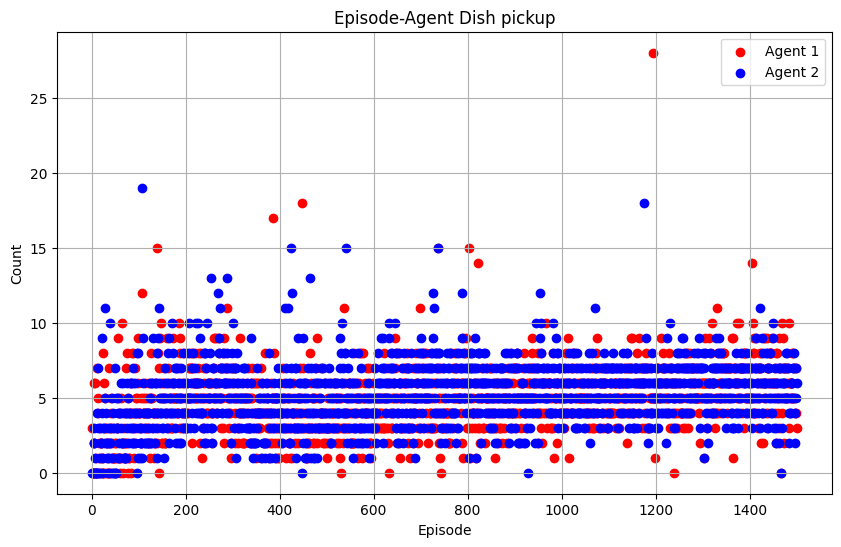

In [31]:
agent1_counts = [count[0] for count in counts]
agent2_counts = [count[1] for count in counts]

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(1, len(counts) + 1), agent1_counts, label='Agent 1', color='red')
plt.scatter(range(1, len(counts) + 1), agent2_counts, label='Agent 2', color='blue')
plt.xlabel('Episode')
plt.ylabel('Count')
plt.title('Episode-Agent Dish pickup')
plt.legend()
plt.grid(True)
plt.show()

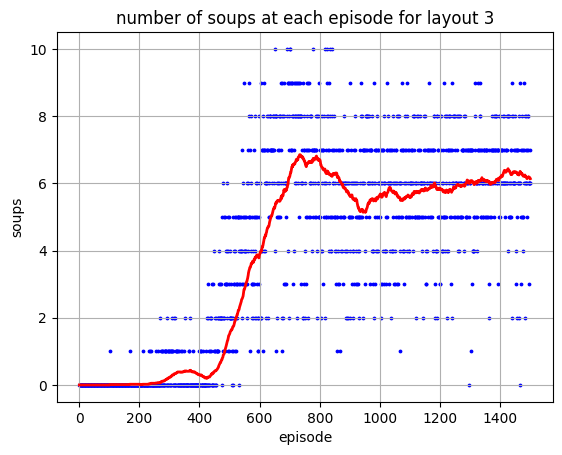

<Figure size 640x480 with 0 Axes>

In [32]:
x1 = [i + 1 for i in range(num_episodes)]
reward_SMA1 = [np.mean(soup_final[max(0, i -100):i+1]) for i in range(num_episodes)]
# plt.plot(x, reward_final, 'o', color ='b', markersize = 3)
plt.scatter(x1, soup_final, color ='b', s=3 )
plt.plot(x1, reward_SMA1, color = 'r', linewidth = 2)
plt.title('number of soups at each episode for layout 3')
plt.xlabel('episode')
plt.ylabel('soups')
# plt.ylim(-500, 500)
plt.grid(True)
plt.savefig('p3.layout3.png')
plt.show()
plt.clf()

In [33]:
num_play = 100
soup_result_100 = []
dish_pickup = []
potting_onion = []


for e in range(num_play):
  terminal = False
    # The number of soups the agent pair made during the episode
  num_soups_made = 0
    # Reset the environment at the start of each episode
  obs = env.reset()
  total_reward = 0

  while not terminal:
        # set pointer to go back overwrite oldest mem if full

        # Obtain observations for each agent
        if env.agent_idx:
            obs0 = obs["both_agent_obs"][1]
            obs1 = obs["both_agent_obs"][0]
        else:
            obs0 = obs["both_agent_obs"][0]
            obs1 = obs["both_agent_obs"][1]

        # EXPERIENCE/STEP
        a0 = agent0.ChooseAction(obs0)
        a1 = agent1.ChooseAction(obs1)
        if env.agent_idx:
            obs, R, terminal, info = env.step([a1,a0])
        else:
            obs, R, terminal, info = env.step([a0,a1])
        num_soups_made += int(R / 20) # Each served soup generates 20 reward

        soup_final.append(num_soups_made)

  dish_pickup.append(info['episode']['ep_game_stats']['dish_pickup'])
  potting_onion.append(info['episode']['ep_game_stats']['potting_onion'])
  # Display status
  print("Ep {0}".format(e + 1), end=" ")
  print("shaped reward agent 0: {0}:".format(r_0), end=" ")
  print("shaped reward agent 1: {0}".format(r_1), end=" ")
  print("no of soups made: {0}".format(num_soups_made))
  soup_result_100.append(num_soups_made)

Ep 1 shaped reward agent 0: 35: shaped reward agent 1: 20 no of soups made: 6
Ep 2 shaped reward agent 0: 35: shaped reward agent 1: 20 no of soups made: 3
Ep 3 shaped reward agent 0: 35: shaped reward agent 1: 20 no of soups made: 6
Ep 4 shaped reward agent 0: 35: shaped reward agent 1: 20 no of soups made: 5
Ep 5 shaped reward agent 0: 35: shaped reward agent 1: 20 no of soups made: 8
Ep 6 shaped reward agent 0: 35: shaped reward agent 1: 20 no of soups made: 7
Ep 7 shaped reward agent 0: 35: shaped reward agent 1: 20 no of soups made: 4
Ep 8 shaped reward agent 0: 35: shaped reward agent 1: 20 no of soups made: 6
Ep 9 shaped reward agent 0: 35: shaped reward agent 1: 20 no of soups made: 7
Ep 10 shaped reward agent 0: 35: shaped reward agent 1: 20 no of soups made: 6
Ep 11 shaped reward agent 0: 35: shaped reward agent 1: 20 no of soups made: 5
Ep 12 shaped reward agent 0: 35: shaped reward agent 1: 20 no of soups made: 6
Ep 13 shaped reward agent 0: 35: shaped reward agent 1: 20 no

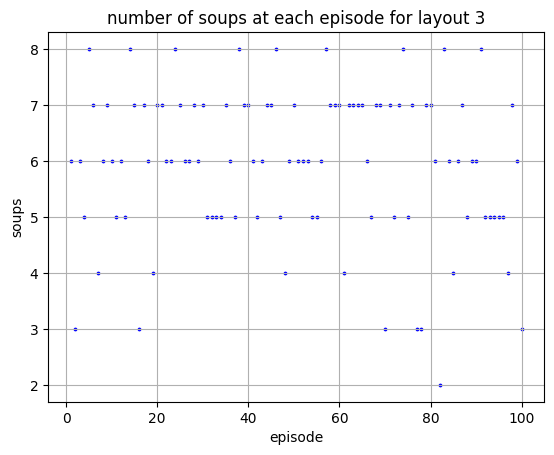

<Figure size 640x480 with 0 Axes>

In [34]:
x1 = [i + 1 for i in range(num_play)]
# plt.plot(x, reward_final, 'o', color ='b', markersize = 3)
plt.scatter(x1, soup_result_100, color ='b', s=3 )
plt.title('number of soups at each episode for layout 3')
plt.xlabel('episode')
plt.ylabel('soups')
# plt.ylim(-500, 500)
plt.grid(True)
plt.savefig('p3.layout3_test.png')
plt.show()
plt.clf()

In [35]:
np.savetxt('lay3_soup_result_100.txt',  soup_result_100)